# Dogs Breed Classification 

In this Research we will try to build a Convolutional neural network that recognizes a dog's breed among other 120 that we'll learn.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf


from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input , Dense, Flatten, Dropout, Conv2D, MaxPool2D

from tensorflow.keras.applications import resnet_v2, inception_resnet_v2

import tensorflow_datasets as tfds
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import TopKCategoricalAccuracy

## Download and preprocess the data

We'll use the Tensorflow API to download and preprocess the dataset.

In [ ]:
dataset, info = tfds.load(name="stanford_dogs", with_info=True)

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteTEUT6L/stanford_dogs-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteTEUT6L/stanford_dogs-test.tfrecord


Dataset stanford_dogs downloaded and prepared to /root/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


One quick check of what we got.

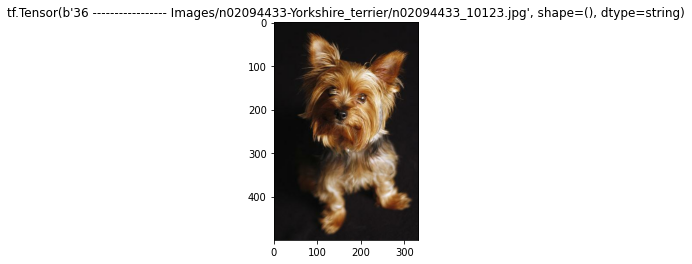

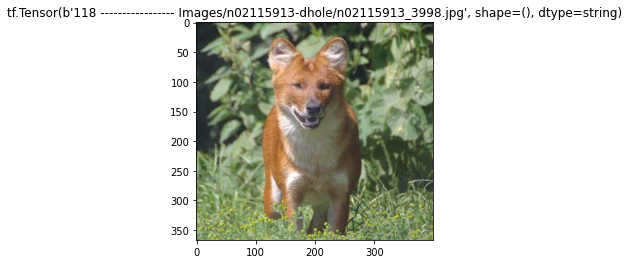

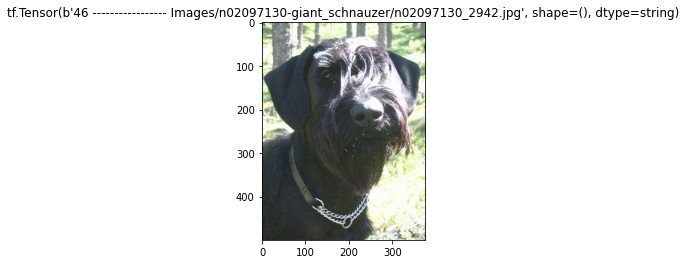

In [ ]:
for x in dataset['train'].take(3):
  plt.imshow(x['image'])
  plt.title(str(x['label'].numpy()) + " ----------------- "+  x['image/filename'])
  plt.show()

## Prepare Transfer Learning and Image processing.

In [ ]:
resnet_inception = inception_resnet_v2.InceptionResNetV2()

225214464/225209952 [==============================] - 1s 0us/step


In [ ]:
len(resnet_inception.layers)

782

In [ ]:
IMG_LEN = 299
IMG_SHAPE = (IMG_LEN, IMG_LEN,3)
N_BREEDS = 120

training_data = dataset['train']
test_data = dataset['test']

def preprocess(ds_row):
  
    image = tf.image.convert_image_dtype(ds_row['image'], dtype=tf.float32)
    image = tf.image.resize(image, (IMG_LEN, IMG_LEN), method='nearest')
  
    label = tf.one_hot(ds_row['label'],N_BREEDS)

    return image, label

def prepare(dataset, batch_size=None):
    ds = dataset.map(preprocess, num_parallel_calls=4)
    ds = ds.shuffle(buffer_size=1000)
    if batch_size:
      ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return ds

Resnet Inception as you saw is a huge model and we will need to change only the last layer. We are going to make it work for our dataset. We will remain with the pre-trained weights of the convolutional layers from Image-net because the Stanford Dogs Dataset is created by the same source anyway, so it should be good.

In [ ]:
resnet_inception = Model(inputs = resnet_inception.layers[0].input, outputs = resnet_inception.layers[780].output)

In [ ]:
for layer in resnet_inception.layers:
  layer.trainable = False

By adding augmentation layer we flip, rotate and zoom the pictures. Not only do we create more data, we also make the model learn harder different positions and features.

In [ ]:
data_augmentation = tf.keras.Sequential(
  [
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(299, 
                                                              299,
                                                              3)),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

## Training

The tuning process has been performed in different folder. Here we will train our model with its final hyperparameters.

In [ ]:
resnet_inception = Sequential([
                           data_augmentation,
                           resnet_inception,
                           Dense(N_BREEDS, activation = 'softmax')
])

We add only one Dense Layer with 120 units to classify for our dataset. The ResnetInception convolutional layers are the huge part of it and we don't need to overkill the process with even more fully conected layers. It's not necessary.

In [ ]:
resnet_inception.compile(optimizer = Adam(learning_rate = 0.00001), loss = 'categorical_crossentropy', metrics = ['accuracy', TopKCategoricalAccuracy(k=3)])

The Adam optimizer works well, the Learning rate is significantly lower than the default one but here we'll only have one final model so we should give it all and for loss we use the categorical cross entropy which is a standard for classification with more labels and the metrics we care about are accuracy and TopKCategoricalAccuracy. The final one is a bit more interesting so let's explain it.

The dataset is hard even for humans. Some of the breeds are very much alike. This is why having this metrics as high as possible is important. We might not be able to tell the difference between Belgian Malinois and German Shepherd but we must for sure conclude it's one of them.

In [ ]:
train_batches = prepare(training_data, batch_size=64)
test_batches = prepare(test_data, batch_size=64)

Prepare the dataset. Let's also have Early stopping based on Validation loss. If it doesn't improve/decline for three straight epochs, we will stop the process.

In [ ]:
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 3)

In [ ]:
history_resnet_inception = resnet_inception.fit(train_batches, validation_data = test_batches,  epochs = 50, callbacks = [early_stopping])

Epoch 1/50
188/188 [==============================] - 141s 656ms/step - loss: 4.8429 - accuracy: 0.0077 - top_k_categorical_accuracy: 0.0308 - val_loss: 4.6705 - val_accuracy: 0.0324 - val_top_k_categorical_accuracy: 0.0830
Epoch 2/50
188/188 [==============================] - 123s 635ms/step - loss: 4.6407 - accuracy: 0.0374 - top_k_categorical_accuracy: 0.0966 - val_loss: 4.4743 - val_accuracy: 0.1030 - val_top_k_categorical_accuracy: 0.2139
Epoch 3/50
188/188 [==============================] - 123s 637ms/step - loss: 4.4516 - accuracy: 0.1106 - top_k_categorical_accuracy: 0.2256 - val_loss: 4.2836 - val_accuracy: 0.2209 - val_top_k_categorical_accuracy: 0.3720
Epoch 4/50
188/188 [==============================] - 123s 635ms/step - loss: 4.2636 - accuracy: 0.2274 - top_k_categorical_accuracy: 0.3950 - val_loss: 4.0963 - val_accuracy: 0.3621 - val_top_k_categorical_accuracy: 0.5723
Epoch 5/50
188/188 [==============================] - 123s 638ms/step - loss: 4.0895 - accuracy: 0.3579 

## Examine the results

We could have used Tensorboard but for the purposes of this report we will do the EDA ourselves here on place. A simple plotting function will do just fine.

In [ ]:
def plot_train_and_validation_results(train, validation, title):
  plt.plot(train)
  plt.plot(validation)
  plt.title(title)
  plt.legend(['Training', 'Validation'])
  plt.show()

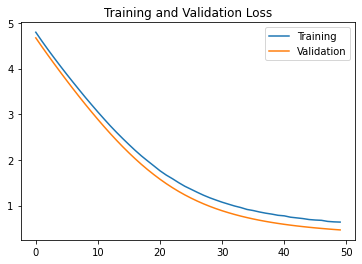

In [ ]:
plot_train_and_validation_results(history_resnet_inception.history['loss'], history_resnet_inception.history['val_loss'], 'Training and Validation Loss' )

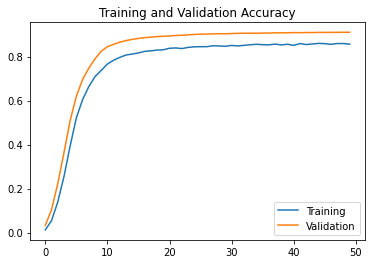

In [ ]:
plot_train_and_validation_results(history_resnet_inception.history['accuracy'], history_resnet_inception.history['val_accuracy'], 'Training and Validation Accuracy' )

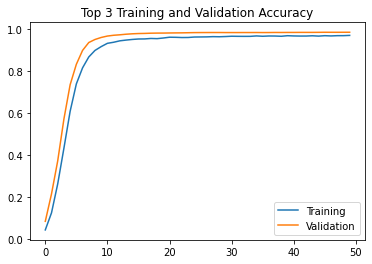

In [ ]:
plot_train_and_validation_results(history_resnet_inception.history['top_k_categorical_accuracy'], history_resnet_inception.history['val_top_k_categorical_accuracy'], 'Top 3 Training and Validation Accuracy' )

### Problems
First things first. Surprisingly or not we've got better performance on validation data. We need to adress that. Is it overfitting, leak, bad distribution or simply easier observations? 

First of all the margin is insignificant and the gap is constantly shrinking. Second, the distribution is fine. Yes, the dataset is not perfectly balanced but its close to that state. Third, the data augmentation and different regularization techniques are not applied to the validation set. Last but not least, the learning graphics look perfectly fine.

### Scores
Let's analyze the results now. Based on both Training and Validation data we should expect between 85%(training) and 91%(validation) accuracy with one guess. The metrics Val Top K Accuracy that we set up to look for the top 3 classes is even greater with between 97-99% score. In other words there is around 91% chance our model to recognize the label instantly and around 98% to put the correct label in a sample of 2 other labels.


### Learning Graphics

Based on the last graphics we could have stopped the model earlier. The Accuracy and  Top K Accuracy didn't improve much from epoch 15 to epoch 50. But they were going up slowly still.  And most importantly the Loss curve looks great. Even though the other two kind of stagnated, the loss learning curve kept getting deeper. Based on the tuning process and the final few epochs it slowed down a bit but the model was still learning and the stagnation of the other two metrics is result of the very hard and relatively small dataset. 

Conclusion - the model was learning and it will continue to learn for at least  few more epochs if we decide to continue or even add more data.

In [ ]:
resnet_inception.save('drive/MyDrive/save_1')

INFO:tensorflow:Assets written to: drive/MyDrive/save_1/assets


INFO:tensorflow:Assets written to: drive/MyDrive/save_1/assets
